In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from math import sqrt

from matplotlib import rcParams, pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.transforms import Affine2D as T

from svgpath2mpl import parse_path

class Tile(object):
    
    def __init__(self, path = None):
        self.bbox = True
        if not path: path = Path([(0,0)])
        self.path = path

    @classmethod
    def read(cls, name):
        with open('{}.path'.format(name)) as _: 
            return cls(
                parse_path(_.read()).transformed(
                    T().scale(1, -1).translate(0, 1)
                )
            )
            
    @staticmethod
    def union(tile0, tile1):
        return Tile(Path.make_compound_path(tile0.path, tile1.path))
            
    @staticmethod
    def transform(tile, transform):
        return Tile(tile.path.transformed(transform))
            
    def _ipython_display_(self):
        fig, ax = plt.subplots()
        ax.add_patch(PathPatch(self.path, fill = False))
        if self.bbox:
            r = Rectangle((0,0), 1, 1, fill = False, linestyle = 'dotted')
            ax.add_patch(r)
        plt.axis('equal')
        plt.axis('off')
        return fig

def flip(tile):
    return Tile.transform(tile, T().scale(-1, 1).translate(1, 0))

def rot(tile):
    return Tile.transform(tile, T().rotate_deg(90).translate(1, 0))

def rot45(tile):
    return Tile.transform(tile,
        T().rotate_deg(45).scale(1 / sqrt(2), 1 / sqrt(2)).translate(1 / 2, 1 / 2)
    )

def over(tile0, tile1):
    return Tile.union(tile0, tile1)

def beside(tile0, tile1, n = 1, m = 1):
    den = n + m
    return Tile.union(
        Tile.transform(tile0, T().scale(n / den, 1)),
        Tile.transform(tile1, T().scale(m / den, 1).translate(n / den, 0))
    )

def above(tile0, tile1, n = 1, m = 1):
    den = n + m
    return Tile.union(
        Tile.transform(tile0, T().scale(1, n / den).translate(0, m / den)),
        Tile.transform(tile1, T().scale(1, m / den))
    )

blank = Tile()
f = Tile.read('f')
fish = Tile.read('fish')
edge = Tile.read('edge')
triangle = Tile.read('triangle')

rcParams['figure.figsize'] = 2,2

# Programming with Escher

This notebook is a collection of *preliminary notes* about a "code camp" (or a series of lectures) aimed at young students inspired by the fascinating [Functional Geometry](https://eprints.soton.ac.uk/257577/1/funcgeo2.pdf) paper of Peter Henderson.

In such work the [Square Limit](https://www.wikiart.org/en/m-c-escher/square-limit) *woodcut* by [Maurits Cornelis Escher](https://en.wikipedia.org/wiki/M._C._Escher) is reconstructed from a set of *primitive* graphical objects suitably *composed* by means of a *functional language*.

Here the approach will be somehow different: first of all because our recipients will be students new to computer science (instead of fellow researchers), but also because besides recalling the fundamental concepts of abstraction levels (and barriers), primitives and composition, present in the original paper, we will here also take the opportunity to introduce some (albeit to some extent elementary) considerations on algebra and geometry, programming and recursion (and perhaps discuss some implementation details).

This work is to be considered *very preliminary*, it is not yet structured in a series of lectures, nor it is worked out the level at which every topic is to be presented, according to the age (or previous knowledge) of the students. The language and detail level used here is intended for instructors and teachers, and the various topics will be listed as mere hints, not yet as a viable and ready to use syllabus.

As a last remark, before actually beginning with the notes, the code of this notebook is very loosely derived from previous "implementations" of Functional Geometry such as [Shashi Gowda](https://github.com/shashi)'s [Julia version](https://shashi.github.io/ijulia-notebooks/funcgeo/) and  [Micah Hahn](https://github.com/micahhahn)'s [Hasjell version](https://github.com/micahhahn/FunctionalGeometry) (containing the [Bézier curve](https://en.wikipedia.org/wiki/B%C3%A9zier_curve) description of the Escher fish used here). I decided to rewrote such code in a [Jupyter](https://jupyter.org/) notebook written in [Python 3](https://www.python.org/), a simple and widespread language, to make it easier for instructors to adopt it.

The [source notebook](https://github.com/mapio/programming-with-escher) is available on GitHub (under [GPL v3](https://www.gnu.org/licenses/gpl-3.0.en.html)), feel free to use [issues](https://github.com/mapio/programming-with-escher/issues) to point out errors, or to [fork it](https://help.github.com/articles/fork-a-repo/) to suggest edits.

## Square Limit and tiles

Looking at the original artwork it is evident that it is obtained by the repetition of a basic element (a fish) that is suitably oriented, scaled, and colored.

![squarelimit](squarelimit.jpg)

This suggest to start our journey from a **tile** (a set of lines enclosed in the unit square), that is a drawing building block, that we will manipulate to obtain more complex drawings.

Note that, if one wants to follow an "unplugged" approach, tiles can be actually printed as objects so that students will be able to experiment with them in the physical world to better introduce themselves with the manipulations that will follow.

It is a good idea to start with an asymmetric tile, that will make it easier to grasp the effect of the transformations that will be presented.


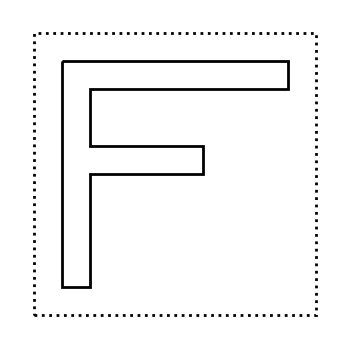

In [2]:
f

Observe that the dotted line is not part of the tile but serves only as a hint for the tile boundary, moreover tiles are implemented in a way that the notebook automatically draws them (without the need of explicit drawing instructions).

## Transforming tiles

We are now ready to introduce some **transformations**, namely `rot`  and `flip` that, respectively, rotate counterclockwise (by 90°) a tile, and flip it around its vertical center.

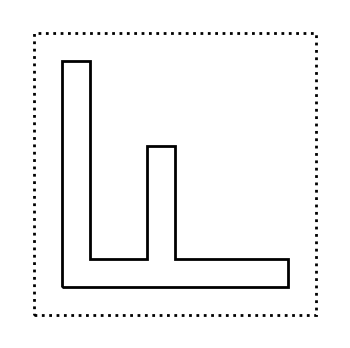

In [3]:
rot(f)

Observe that the notation is the usual one for *function* application, that should be immediately clear even to students new to programming (but with a basic understanding of mathematical notation). Of course one can *compose* such transformations insomuch function can be composed, that is performed one on the result of another.

The first observation is that the *order* in which such transformation are performed can make a difference. Consider for instance

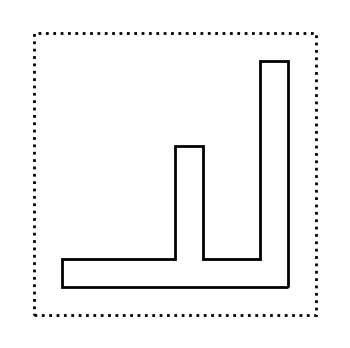

In [4]:
flip(rot(f))

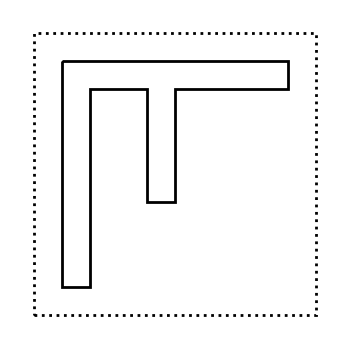

In [5]:
rot(flip(f))

The second observation is that some choices, that can seem at first restrictive, can become less of a limitation thanks to composition: we can obtain clockwise rotations by applying three counterclockwise rotations

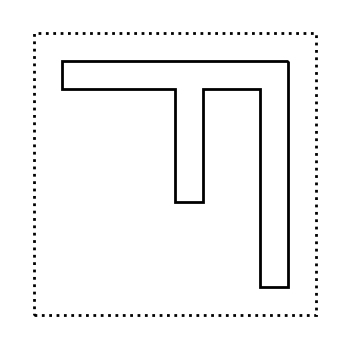

In [6]:
rot(rot(rot(f)))

this can stimulate a discussion about the *expressiveness* or *completeness* of a set of *primitives* with respect to an assigned set of tasks.

Then a few *binary* transformations (that is, transformation that operate on two tiles) can be introduced, such as: `above`, `beside` and `over`. The first two combine two tiles by juxtaposition (rescaling the final result so that it will again fit in a unit square), while the latter just lay one tile over another.

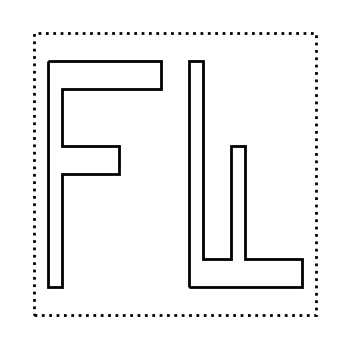

In [7]:
beside(f, rot(f))

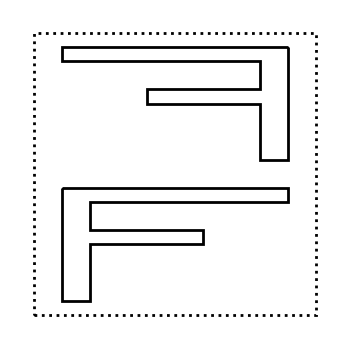

In [8]:
above(flip(f), f)

Again one can observe that the order of the arguments is relevant, in the case of these two transformation, while it is not in the case of the latter.

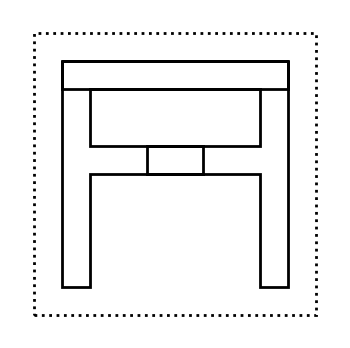

In [9]:
over(f, flip(f))

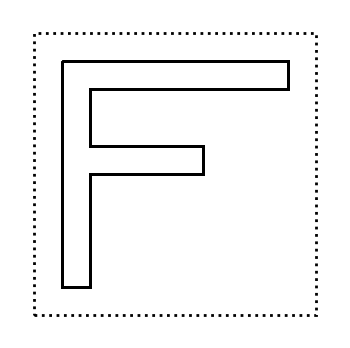

In [11]:
over(f, f)

## Basic algebraic facts about transformations

Such transformations can be also implemented as binary operators (thanks to Python ability to define classes that [emulate numeric types](https://docs.python.org/3/reference/datamodel.html#emulating-numeric-types)); one can for instance use `|` and `/` respectively for `beside` and `above`, and `+` for `over`.

In [12]:
class TileWithOperations(Tile):
    @staticmethod
    def addop(tile):
        t = TileWithOperations()
        t.path = tile.path
        return t
    def __add__(self, other):
        return TileWithOperations.addop(over(self, other))
    def __truediv__(self, other):
        return TileWithOperations.addop(above(self, other))
    def __or__(self, other):
        return TileWithOperations.addop(beside(self, other))

f = TileWithOperations.addop(f)

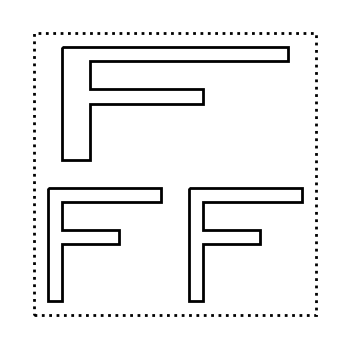

In [13]:
f / ( f | f )

This will allow to investigate (with a natural syntax) basic algebraic structures as (*abelian* or not) *semigroups*, and even *monoids*, once a blank tile is been introduced, as well as more simple concepts as *associativity* and *commutativity*,

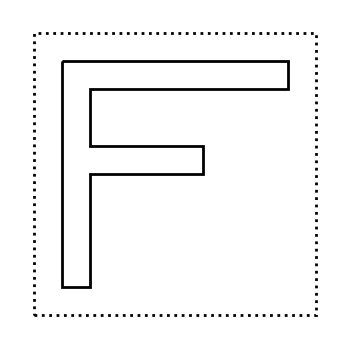

In [14]:
f + blank

## Recursion

It can be quite natural to introduce functions, initially presented as a sort of macros, to build derived operators. For instance

In [15]:
def quartet(p, q, r, s):
    return above(beside(p, q), beside(r, s))

is a new transformation, defined in terms of the previous one.

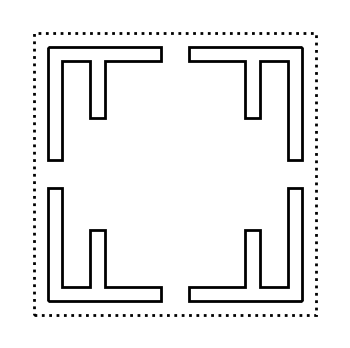

In [16]:
quartet(flip(rot(rot(rot(f)))), rot(rot(rot(f))), rot(f), flip(rot(f)))

Then **recursion** can be introduced quite naturally to build tiles having self-similar parts. Let's use a triangle to obtain a more pleasing result

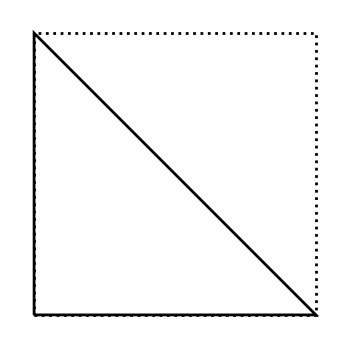

In [17]:
triangle

Let's build a tile where the upper left quarter is a (rotated) triangle surrounded by three tiles similarly defined

In [19]:
def rectri(n):
    if n == 0: 
        return blank
    else:
        return quartet(rot(triangle), rectri(n - 1), rectri(n - 1), rectri(n - 1))

developing the first four levels gives 

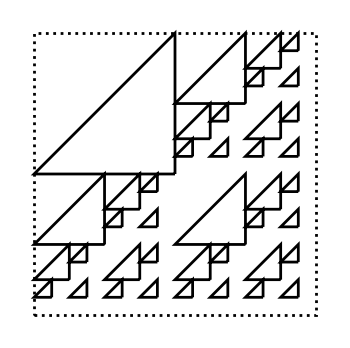

In [20]:
rectri(4)

Once can even push things further and show how to use of recursion instead of iteration, emphasizing how expressive a simple set of basic transformation, endowed with composition and recursion, can become.

## Extending the basic transformations

What if we want to write `nonet`, a version of `quartet` that puts together nine tiles in a $3\times 3$ arrangement? The given `beside` and `above` transformations are halving the width and height of the tiles they operate on, as it is easy to convince oneself, there is no way to use them to implement `nonet`.

To overcome such limitation, one can extend those transformations so that one can specify also the relative sizes of the combined tiles. For instance, in

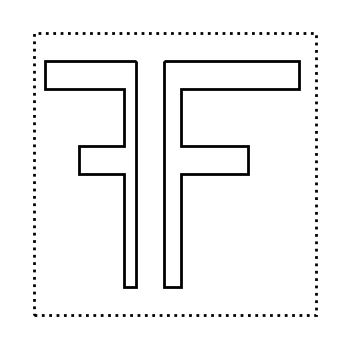

In [21]:
beside(flip(f), f, 2, 3)

the flipped `f` takes $2/5$ of the final tile, whereas `f` takes the other $3/5$. Using such extended transformations one can define

In [22]:
def nonet(p, q, r, s, t, u, v, w, x):
    return above(
            beside(p, beside(q, r), 1, 2),
            above(
                beside(s, beside(t, u), 1, 2),
                beside(v, beside(w, x), 1, 2), 
            ),
            1, 2
    )

to obtain the desired result

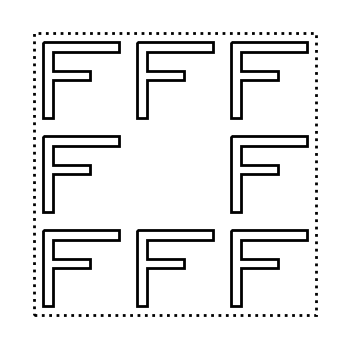

In [23]:
nonet(
    f, f,     f, 
    f, blank, f, 
    f, f,     f
)

of course, according to the way one decomposes the $3\times 3$ tile as a combination of two sub-tiles, there are many alternative ways to define `nonet` that students can experiment with.

Another possible approach will be to have `above`, `beside` (and `over`) accept a *variable number of arguments* (thanks to the way functions are [defined](https://docs.python.org/3/reference/compound_stmts.html#function) and [called](https://docs.python.org/3/reference/expressions.html#calls) in Python). In such case, otaining the `nonet` will be trivial.

## Decomposing the woodcut

The basic building block of the woodcut is a fish

In [24]:
rcParams['figure.figsize'] = 4, 4

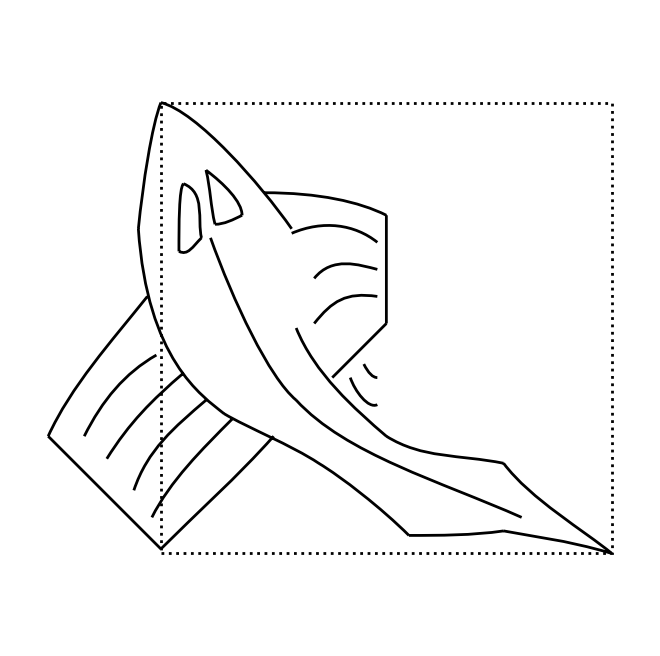

In [25]:
fish

even if it is not completely contained in a tile (the unit square), Escher choose (we'll discuss such magic in the following) a shape able to fit with his own rotation

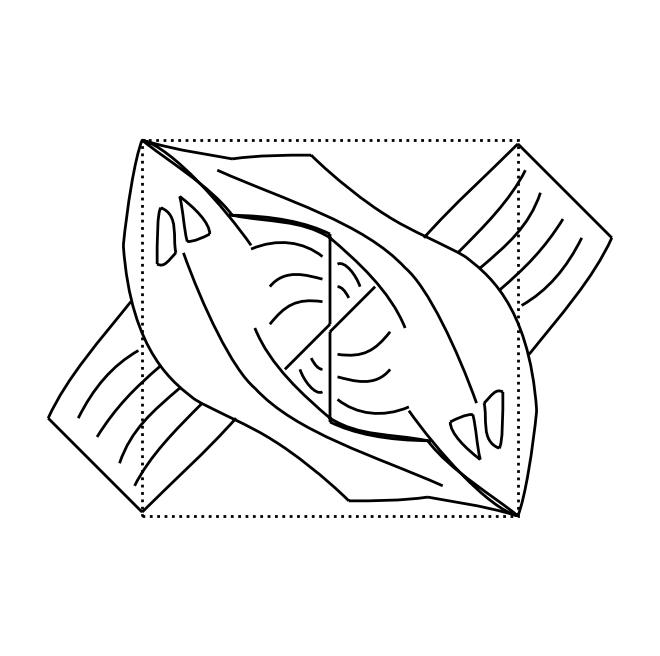

In [26]:
over(fish,rot(rot(fish)))

But this is not the only magic. Let's define a new transformation that is a 45° rotation and a rescaling (by a $\sqrt 2$ factor) that, somehow, will "lift up" half tile; using it on `triangle` should clarify its definition

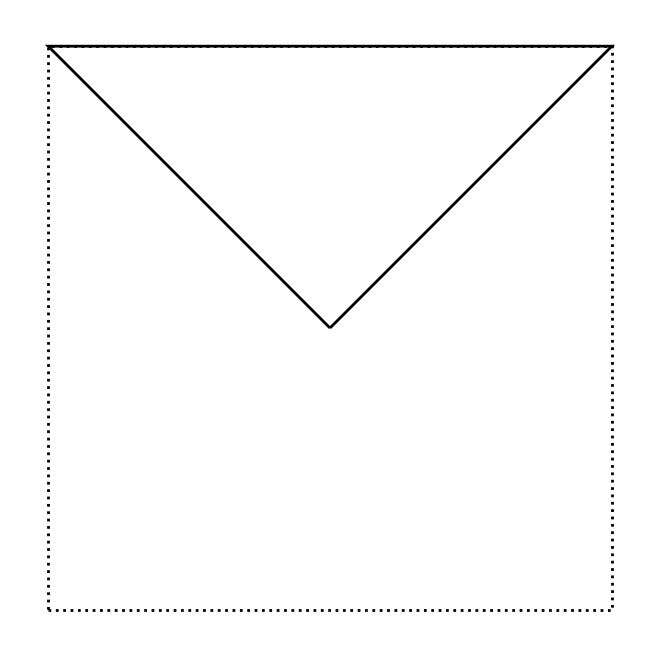

In [27]:
rot45(triangle)

Well, the fish is so magic that if we transform it with such new rotation and `flip` it

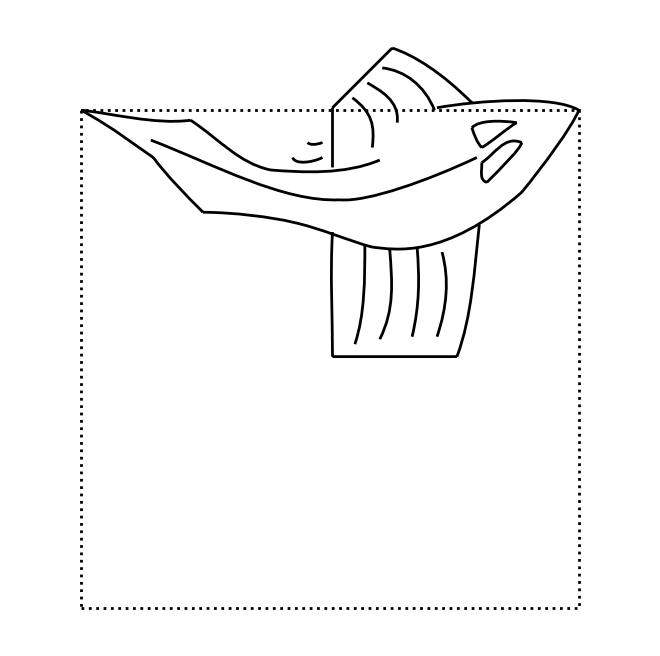

In [28]:
smallfish = flip(rot45(fish))
smallfish

we obtain a new tile that will fit with the original `fish`, even if rotated again

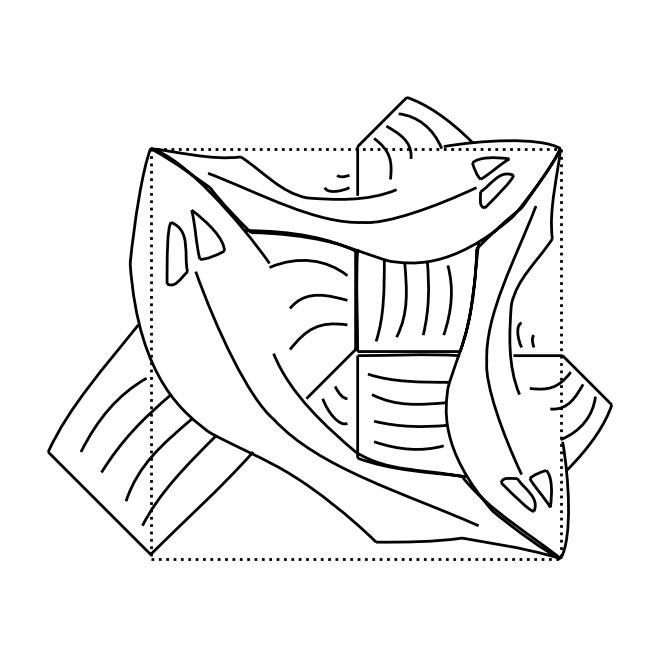

In [29]:
t = over(fish, over(smallfish, rot(rot(rot(smallfish)))))
t

and will moreover fit with itself however rotated

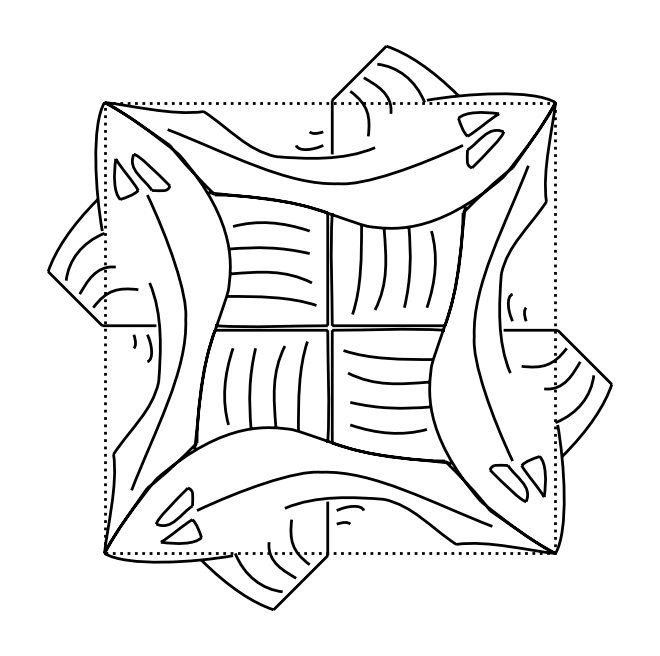

In [30]:
u = over(over(over(smallfish, rot(smallfish)), rot(rot(smallfish))), rot(rot(rot(smallfish))))
u

The `t` and `u` tiles just defined are the building blocks of the woodcut; a recursive definition of the side, based just on `t` is given by

In [ ]:
def side(n):
    if n == 0: 
        return blank
    else: 
        return quartet(side(n-1), side(n-1), rot(t), t)

Expanding the first two levels gives

In [ ]:
side(2)

Similarly, a recursive definition of the corner, based on the `side` and `u` is given by

In [ ]:
def corner(n):
    if n == 0:
        return blank
    else:
        return quartet(corner(n-1), side(n-1), rot(side(n-1)), u)

As before, the first two levels are

In [ ]:
corner(2)

We now can use a `nonet`  to put together the (suitably rotated) sides and corners, as follows

In [ ]:
def squarelimit(n):
    return nonet(
        corner(n), 
        side(n), 
        rot(rot(rot(corner(n)))), 
        rot(side(n)), 
        u, 
        rot(rot(rot(side(n)))),
        rot(corner(n)), 
        rot(rot(side(n))), 
        rot(rot(corner(n)))
    )

Expanding the first three levels gives

In [ ]:
rcParams['figure.figsize'] = 20, 20

In [ ]:
squarelimit(3)

### The magic fish

What is actually even more magic is that (the outline) of the fish, that makes it fit with himself in so many ways, can be obtained just from a simple line

In [ ]:
rcParams['figure.figsize'] = 4, 4

In [ ]:
edge

this can be duplicated and transformed with `rot45` to obtain the left side of the fish

In [ ]:
outline2 = over(
    rot45(flip(rot(edge))),
    rot(rot(rot45(flip(rot(edge)))))
)
outline2

to obtain the other side of the fish we need to rotate the `edge` and to translate it outside of the boundary of the tile… this can't be accomplished with the basic transformations we introduced above, but more directly as

In [ ]:
outline3 = Tile.transform(rot(edge), T().translate(-1,0))
outline3

we are now ready to put together the three edges to obtain the fish

In [ ]:
outline = over(edge, Tile.union(outline3, outline2))
outline

the role of the basic `edge` can become more clear if we add the `triangle` tile

In [ ]:
over(triangle, outline)

By drawing the `squarelimit` using the `triangle` as a basic tile helps understanding the magic of how the tiles fit

In [ ]:
def _t(base):
    t2 = flip(rot45(base))
    t3 = rot(rot(rot(t2)))
    return over(base, over(t2, t3))

def _u(base):
    t2 = flip(rot45(base))
    return over(over(t2, rot(t2)), over(rot(rot(t2)), rot(rot(rot(t2)))))

t = _t(triangle)
u = _u(triangle)

In [ ]:
squarelimit(3)

Perhaps even better if we use the `outline`

In [ ]:
t = _t(outline)
u = _u(outline)

In [ ]:
squarelimit(3)

## Implementation notes

Implementing the above primitives can be done in so many ways, that is hard to argue which will be the better.

Here all the drawing is made using [Matplotlib](https://matplotlib.org), probably the most common Python plotting library; few details of our implementation are:

* the [matplotlib.path.Path](https://matplotlib.org/api/path_api.html#matplotlib.path.Path), that "represents a series of possibly disconnected, possibly closed, line and curve segments" is used as a basic building block for tiles;

* such paths can be easily *transformed* using [matplotlib.transforms.Affine2D](https://matplotlib.org/api/transformations.html#matplotlib.transforms.Affine2D) that very conveniently perform scaling and translations;

* once the path with the desired shape is obtained, it can be turned in a [matplotlib.patches.PathPatch](https://matplotlib.org/api/patches_api.html#matplotlib.patches.PathPatch) that can be straightforwardly rendered by [matplotlib.axes.Axes.add_patch](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.add_patch.html).

Of course, instead of using the Matplotlib code for transformation one can take the opportunity to introduce more in detail the *affine transformations*, providing a simple "hand made" implementation.s